# 几何光学 Project： Understand Spherical Aberration

Write codes for generating spot diagrams for lenses.

Only Snell’s Law is simply used. 
Basic system requirements are:

$$
\begin{align}
Aperture\space Diameter &= 30 mm\\
EFL &=100 mm\\
n &= 1.51680\\
Lens\space thickness  &= 7.2 mm\\
\end{align}
$$

Plot spot diagram
Find the minimized GEO (Geometrical radius) on Gaussian image plane.

## 第3问(Not required, for bonus only)


To minimize the spot size by splitting a lens into two.Then there are four curvatures C1, C2, C3 and C4 for you to change for minimizing spot size. Lens thicknesses are 7.2 mm. Find the minimized GEO.

#### 几何光学第三问的报告主要分3个部分

#### 1. 实验结果
#### 2. 实验优化部分
#### 3. 实验可视化
#### 4. 实验总结




### 实验结果

优化得到了几组参数，他们的最优解，即最小的$GEO$均在**68.5微米左右**:
几组参数如下：

$$
d_1 = 3.794534148747353, R_1 = 119.69273909894815, R_2 = -767.0064369194129, R_3 = 63.659388754759384, R_4 = 164.5631912337114
$$

$$
d_1 = 3.176360357053351, R_1 = 119.72954308566115, R_2 = -769.3878656036064, R_3 = 63.80625327185889, R_4 = 164.30861674554382
$$

$$
d_1 = 3.4, R_1 = 119.7199977677967, R_2 = -768.4283763202156, R_3 = 63.7533189260608, R_4 = 164.404943741207
$$

$$
d_1 = 3.5, R_1 = 119.71429083121654, R_2 = -767.9949059205088, R_3 = 63.73037787869639, R_4 = 164.449973548185
$$

$$
d_1 = 3.6, R_1 = 119.70411574974297, R_2 = -767.7266215171246, R_3 = 63.70529705340449, R_4 = 164.479277598298
$$

$$
3.7, R_1 = 119.1665898637995, R_2 = -752.8302238207918, R_3 = 63.587866788963936, R_4 = 162.153645880908
$$

**前两组参数没有对$d_1$进行约束。但实验表明，在一定范围内定死$d_1$的值，依然可以得到相同的最优$GEO$。例如后四组参数。**

Ray Tracing的可视化结果（实验未作要求）Spot Diagram的可视化结果分别如下：

In [55]:
from IPython.display import Image
rt3 = Image(filename='./rt3.png')
sd3 = Image(filename='./sd3.png') 

Ray Tracing的结果（实验未作要求）:

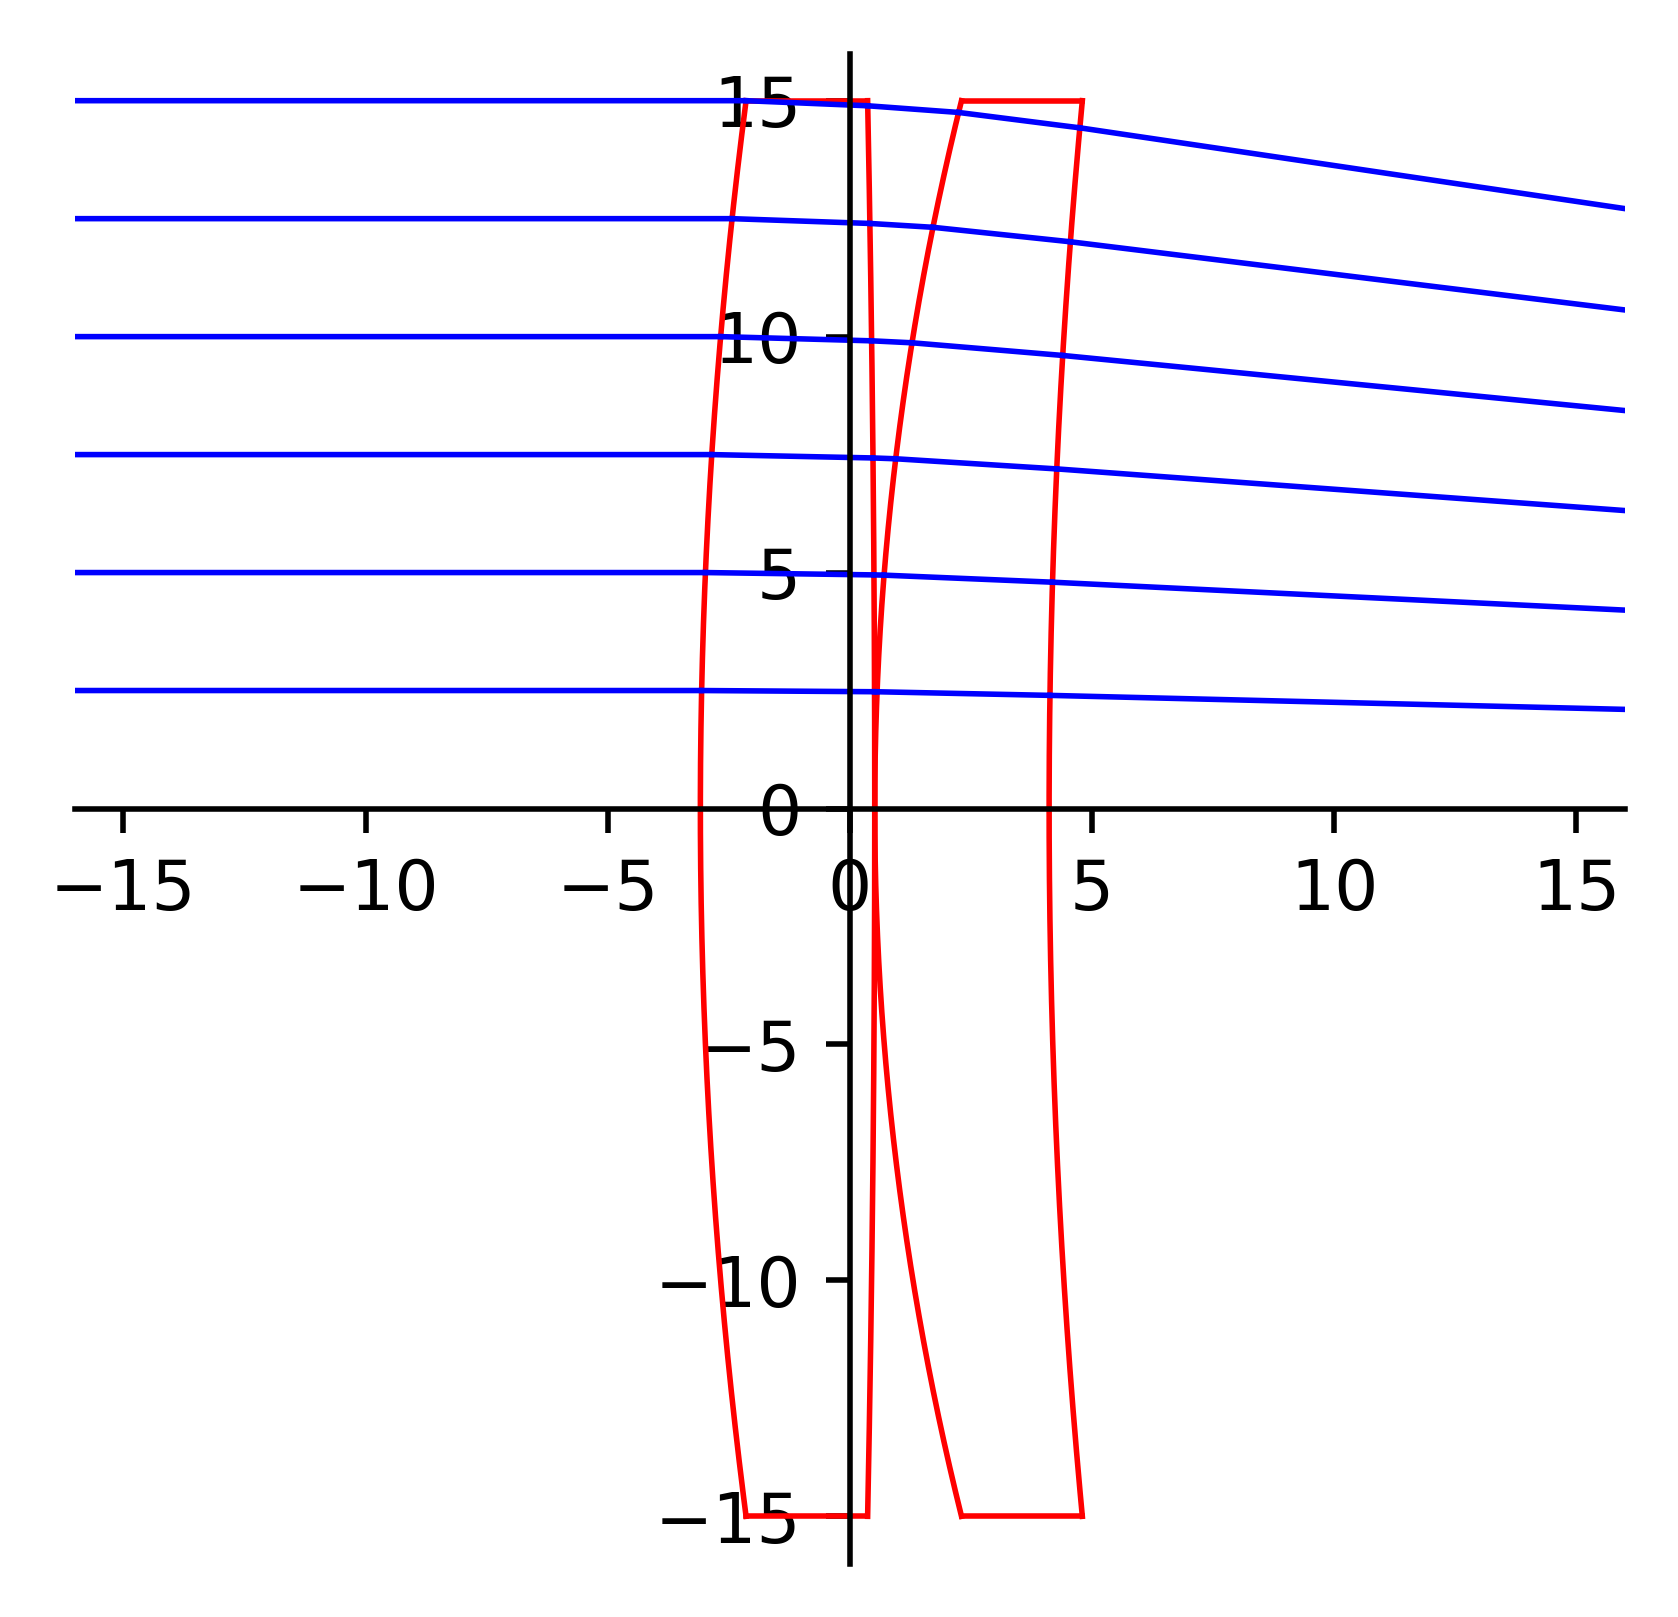

In [56]:
rt3

Spot Diagram的结果:

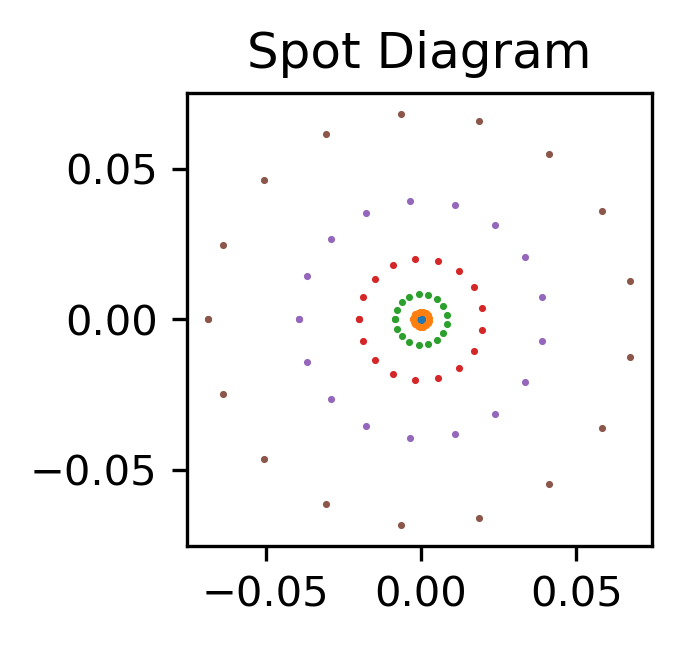

In [58]:
sd3

### 2. 实验优化部分

这个实验的优化过程是很艰辛的...

首先，需要建立新的模型。实验1和实验2的模型效率低且代码量多。在做实验3时候，我充分利用了Python内置的list， dict等数据结构。广泛利用lambda匿名函数是的代码更加简洁。

其次，我需要证明我的Ray Tracing模型是对的。我采用如下方法：把实验一和实验二的参数代入，应该能得到相同的结果。事实也是如此。这可以比较充分的证明模型的有效性。（时间空间有限，这里就不在给验证的结果了，可以利用源码自行检验。）

优化部分采用了scipy包里面的优化器。scipy提供丰富的优化手段。具体可以查看这个[官方文档](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)。

对于本实验而言，有四个变量$$C_1, C_2, C_3, C_4$$。可以用他们解出$d_1, d_2$的值。这是最直接的思路。

但是，实际操作起来，解出$d_1, d_2$的值耗时很长，也经常无解或者得到虚根从而使得迭代器停止迭代。

事实上，对于$$C_1, C_2, C_3, C_4$$和$d_1, d_2$六个变量，知道其中四个就可以解出另外两个。故选择1个$d$，3个$C$作为参量比较合适。

事实证明，这样设参数，优化速度很快。且很容易得到实根。

这里采用迭代优化的方法解决。具体采用的算法是[SLSQP](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html)。

以下就是优化部分的代码

In [ ]:


# 导入必要的第三方包
import time
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy.optimize import *


cpu_start = time.clock()  


def f(arg, h=30):
    
    K = 1 / 100
    mu = 1.51680
    d = 7.2
    apt_d = h
    
    d1, c11, c12, c21 = arg 
    d2 = d - d1
    c22 = sym.symbols('c_22')
    
    K1 = (mu - 1) * (c11 - c12) + (d1 / mu) * c11 * c12 * (mu - 1) ** 2
    K2 = (mu - 1) * (c21 - c22) + (d2 / mu) * c21 * c22 * (mu - 1) ** 2
    
    K11 = c11 * (mu - 1)
    K12 = c12 * (1 - mu)
    K21 = c21 * (mu - 1)
    K22 = c22 * (1 - mu)
    
    delta_1 = (d1 * K12) / (mu * K1)
    delta_1P = -(d1 * K11) / (mu * K1)
    delta_2 = (d2 * K22) / (mu * K2)
    delta_2P = -(d2 * K21) / (mu * K2)
    
    d_P = delta_2 - delta_1P
    eq_K = K1 + K2 - d_P * K1 * K2
    
    sol = sym.solve(eq_K - K, c22)
    c22 = sol[0]
    

    R11, R12, R21, R22 = 1/c11, 1/c12,  1/c21, 1/c22
    
    K1 = (mu - 1) * (c11 - c12) + (d1 / mu) * c11 * c12 * (mu - 1) ** 2
    K2 = (mu - 1) * (c21 - c22) + (d2 / mu) * c21 * c22 * (mu - 1) ** 2
    
    K11 = c11 * (mu - 1)
    K12 = c12 * (1 - mu)
    K21 = c21 * (mu - 1)
    K22 = c22 * (1 - mu)
    
    delta_1 = (d1 * K12) / (mu * K1)
    delta_1P = -(d1 * K11) / (mu * K1)
    delta_2 = (d2 * K22) / (mu * K2)
    delta_2P = -(d2 * K21) / (mu * K2)
    
    d_P = delta_2 - delta_1P
    eq_K = K1 + K2 - d_P * K1 * K2
    delta_P = -(d_P*K1)/K
    delta   =  (d_P*K2)/K
    
    x_C11 = -delta_P -delta_2P - d  + R11
    x_C12 = -delta_P -delta_2P - d2 + R12
    x_C21 = -delta_P -delta_2P - d2 + R21
    x_C22 = -delta_P -delta_2P      + R22
    
    x_C_ = np.array([[x_C11, x_C12], 
            [x_C21, x_C22]])
    
    R_  =  np.array([[R11 , R12], 
            [R21 , R22]])
        

    theta = sym.Symbol('theta')
    
    x_bd_func_l = [[lambda theta, xc=xc, r=r: xc + r*sym.cos(theta) \
                      for xc, r in zip(xC, R)] \
                      for xC, R in zip(x_C_, R_)]
    
    
    y_bd_func_l = [[lambda theta, r=r: r*sym.sin(theta) \
                       for r in R] \
                       for R in R_]
    
    x_bd_l     = [[{}, {}],
                  [{}, {}]]
    
    y_bd_l     = [[{}, {}],
                  [{}, {}]]
    
    theta_bd_l = [[{}, {}],
                  [{}, {}]]
    
     
    x = sym.symbols('x')
    
    y_c_f_ = [[lambda x, r=r, xc=xc: (r**2 - (x - xc)**2)**(1/2) \
             for r, xc in zip(R, x_C)] \
             for R, x_C in zip(R_, x_C_)]
    
    y_l_ = [[mu, 1], [mu, 1]]
    
    yl = lambda x: 0*x + apt_d/2
    
    n_l = [[1, mu], [1, mu]]
    
    n_P_l = [[mu, 1], [mu, 1]]
    
    def get_its_pt():
        x0_l = sym.solve(yl(x) - ycf(x), x)
        if len(x0_l) == 1:
            x0 = x0_l[0]
        else:
            if R_[i][j] > 0:
                x0 = x0_l[0] 
            else:
                x0 = x0_l[1]
        y0 = ycf(x0)
        return x0, y0
    
    def normal(): return float(sym.re((-1/((x_C_[i][j] - x0)/(R_[i][j]**2 - (x0 - x_C_[i][j])**2)**(1/2)))))
    
    def transfer():
        i   = np.arctan(k) - np.arctan(k_n)
        i_P = np.arcsin(n*np.sin(i)/n_P)
        k_P = np.tan(np.arctan(k_n) + i_P)
    #     print(i_P)
        return lambda x: k_P*(x - x0) + y0
    
    
    for i in range(2):
        for j in range(2):
            n = n_l[i][j]
            n_P = n_P_l[i][j]
            k = float(sym.diff(yl(x), x))
            y_l_[i][j] = yl
            ycf = y_c_f_[i][j]
            x0, y0 = get_its_pt()
            k_n = normal()
            yl = transfer()
    return abs(yl(1/eq_K))



res_l = []

for d1 in [3.4, 3.5, 3.6, 3.7, 3.75]:
    
    arg_init = [d1, 0.005, -0.005, 0.01]
    
    bd_d = (d1, d1)
    bd_c11 = (-1/100, 1/50)
    bd_c12 = (-1/50, 1/100)
    bd_c21 = (-1/100, 1/50)
    bds = (bd_d, bd_c11, bd_c12, bd_c21)
    
    con = {'type': 'ineq', 'fun': lambda c: 0.02 - f(c, 30)}
    
    res = minimize(f, arg_init, method='SLSQP', bounds=bds, constraints=con, options={'maxiter': 9})
    print(res.x)
    res_l.append(res)
    
cpu_end = time.clock()  
print('CPU时间(cpu time):', cpu_end - cpu_start, 's')

            

[     fun: 0.06859236701619587
     jac: array([ 5.54323196e-05,  2.68958807e-02, -2.51444578e-02, -1.35096312e-02])
 message: 'Iteration limit exceeded'
    nfev: 67
     nit: 9
    njev: 9
  status: 9
 success: False
       x: array([ 3.40000000e+00,  8.35737060e-03, -1.30149881e-03,  1.56814878e-02]),      fun: 0.06859007033440356
     jac: array([ 7.29441643e-04,  4.58788872e-03, -7.09295273e-05,  1.88869238e-02])
 message: 'Iteration limit exceeded'
    nfev: 69
     nit: 9
    njev: 9
  status: 9
 success: False
       x: array([ 3.50000000e+00,  8.35479928e-03, -1.30091993e-03,  1.56962917e-02]),      fun: 0.06858775876725254
     jac: array([ 0.00032306,  0.00113118, -0.0009588 ,  0.00026906])
 message: 'Iteration limit exceeded'
    nfev: 70
     nit: 9
    njev: 9
  status: 9
 success: False
       x: array([ 3.60000000e+00,  8.35409919e-03, -1.30252500e-03,  1.56973408e-02]),      fun: 0.06897082900235496
     jac: array([-1.88708305e-04, -1.05414200e+00, -3.89685154e-01, -6

以上是优化器所得参数。
其中，fun是输出，也就是GEO。

**具体的参数写在第一部分了，已经将曲率转化为半径，易于用Zemax验证**

**报告中没有加入没有定死d的情况，如有需要，直接在源代码处修改d的区间就好。推荐区间是3.3~3.8**

In [ ]:
[ 3.40000000e+00  8.35282341e-03 -1.30135746e-03  1.56854579e-02]
[ 3.50000000e+00  8.35322160e-03 -1.30209197e-03  1.56911042e-02]
[ 3.60000000e+00  8.35393164e-03 -1.30254699e-03  1.56972818e-02]
[ 3.70000000e+00  8.39161380e-03 -1.32832074e-03  1.57262706e-02]

（以上是以前一些原始结果。也是正确的。但未转换为易于Zemax验证的形式）

### 3. 实验结果可视化

#### 可视化分两部分，一是Ray Tracing，而是Spot Diagram


In [45]:
K = 1 / 100
mu = 1.51680
d = 7.2
apt_d = 30

In [46]:
# 求解基本参量

d1 = 3.6
d2 = d - d1

c11, c12, c21, c22 =  [0.00835379616550218, -0.0013041585781064374, 0.01569771347841251, 0.00608177762698585]
R11, R12, R21, R22 = 1/c11, 1/c12, 1/c21, 1/c22

def get_d1_d2(solve=True, d1 = sym.symbols('d_1'), d2 = sym.symbols('d_2')):
    # 分别求两个透镜的光焦度K1，K2
    
    K1 = (mu - 1) * (c11 - c12) + (d1 / mu) * c11 * c12 * (mu - 1) ** 2
    K2 = (mu - 1) * (c21 - c22) + (d2 / mu) * c21 * c22 * (mu - 1) ** 2

    K11 = c11 * (mu - 1)
    K12 = c12 * (1 - mu)
    K21 = c21 * (mu - 1)
    K22 = c22 * (1 - mu)

    # 两个透镜主面的位置
    delta_1 = (d1 * K12) / (mu * K1)
    delta_1P = -(d1 * K11) / (mu * K1)
    delta_2 = (d2 * K22) / (mu * K2)
    delta_2P = -(d2 * K21) / (mu * K2)

    d_P = delta_2 - delta_1P
    eq_K = K1 + K2 - d_P * K1 * K2

    if solve:
        sol = sym.solve([eq_K - K, d1 + d2 - d], [d1, d2])
        for i in range(len(sol)):
            if sym.re(sol[i][0]) > 0 and sym.re(sol[i][1]) > 0:
                d1, d2 = np.abs(sym.re(sol[i][0])), np.abs(sym.re(sol[i][1]))
                pass
        print(d1, d2)
        return get_d1_d2(False, d1, d2)
    
    else:
        delta_P = -(d_P*K1)/K
        delta   =  (d_P*K2)/K
        
        x_C11 = -delta_P -delta_2P - d  + R11
        x_C12 = -delta_P -delta_2P - d2 + R12
        x_C21 = -delta_P -delta_2P - d2 + R21
        x_C22 = -delta_P -delta_2P      + R22
        
        x_C_ = np.array([[x_C11, x_C12], 
                [x_C21, x_C22]])
        
        R_  =  np.array([[R11 , R12], 
                [R21 , R22]])
        
        return x_C_, R_
    
        
x_C_, R_ = get_d1_d2(False, d1, d2)




In [47]:
# 求解光线方程

def ray_tracing(h=30, draw=True):    
    x = sym.symbols('x')

    y_c_f_ = [[lambda x, r=r, xc=xc: (r**2 - (x - xc)**2)**(1/2) \
             for r, xc in zip(R, x_C)] \
             for R, x_C in zip(R_, x_C_)]

    y_l_ = [[0, 0], [0, 0]]

    yl = lambda x: 0*x + h/2

    y_intvl_func = [lambda x: 0*x + h/2]

    n_l = [[1, mu], [1, mu]]

    n_P_l = [[mu, 1], [mu, 1]]

    transfer_arg_list = [[],0,0,0,0]

    def get_its_pt():
        x0_l = np.array(sym.solve(yl(x) - ycf(x), x))
        x0 = x0_l[np.argmin(np.abs(x0_l))]
        y0 = ycf(x0)
        return x0, y0

    def normal(): return float(-1/((x_C_[i][j] - x0)/(R_[i][j]**2 - (x0 - x_C_[i][j])**2)**(1/2)))

    def transfer():
        i   = np.arctan(k) - np.arctan(k_n)
        i_P = np.arcsin(n*np.sin(i)/n_P)
        k_P = np.tan(np.arctan(k_n) + i_P)
        return [k_P, x0, y0], lambda x, k_P=k_P, x0=x0, y0=y0: k_P*(x - x0) + y0

    x_intvl = []
    y_intvl = []

    z = 1
    for i in range(2):
        for j in range(2):
            n = n_l[i][j]
            n_P = n_P_l[i][j]
            k = float(sym.diff(yl(x, *transfer_arg_list[z-1]), x))
            ycf = y_c_f_[i][j]
            x0, y0 = get_its_pt()
            x_intvl.append(x0)
            y_intvl.append(y0)
            k_n = normal()
            transfer_arg_list[z], yl = transfer()
            y_intvl_func.append(yl)
            z += 1


    x_intvl = [-120] + x_intvl + [120]
    
    if draw:
        for i in range(5):
            x = np.arange(x_intvl[i], x_intvl[i+1], 0.01)
            plt.plot(x, y_intvl_func[i](x, *transfer_arg_list[i]), 'b', linewidth=0.8)
    
    r = yl(1/K)

    return r



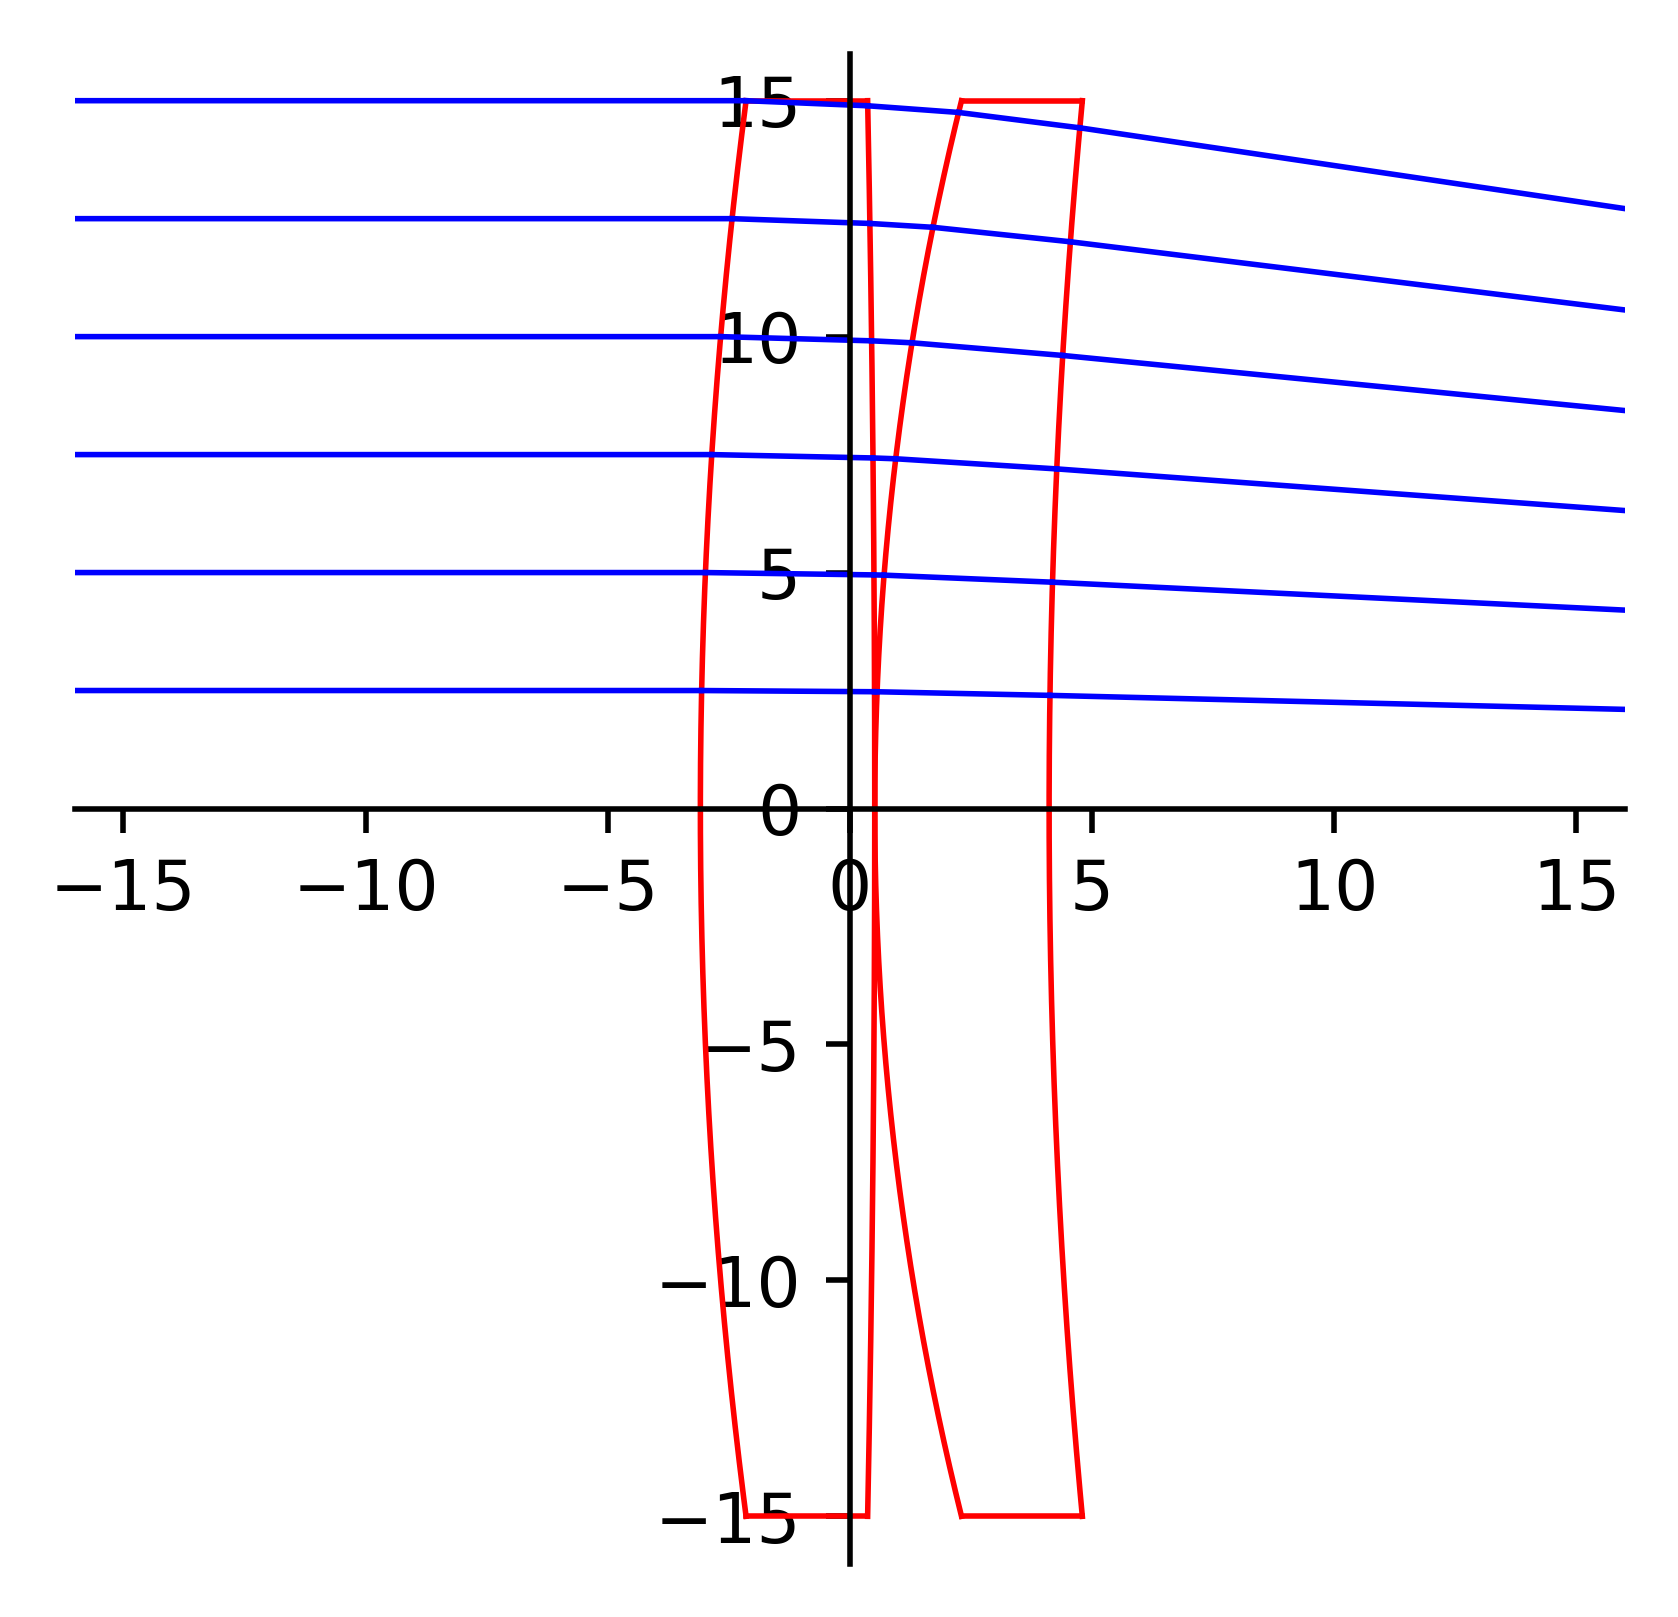

CPU时间(cpu time): 27.91432900000018 s


In [50]:
# 作图代码

import time

cpu_start = time.clock()  


theta = sym.Symbol('theta')

x_bd_func_l = [[lambda theta, xc=xc, r=r: xc + r*sym.cos(theta) \
                  for xc, r in zip(xC, R)] \
                  for xC, R in zip(x_C_, R_)]


y_bd_func_l = [[lambda theta, r=r: r*sym.sin(theta) \
                   for r in R] \
                   for R in R_]

x_bd_l     = [[{}, {}],
              [{}, {}]]

y_bd_l     = [[{}, {}],
              [{}, {}]]

theta_bd_l = [[{}, {}],
              [{}, {}]]

def abs_smaller(a):return np.argmin(np.abs(np.array(a)))
    
for i in range(2):
    for j in range(2):
        upper = sym.solve(y_bd_func_l[i][j](theta) - apt_d/2, theta)
        lower = sym.solve(y_bd_func_l[i][j](theta) + apt_d/2, theta)
        
        k = abs_smaller([x_bd_func_l[i][j](upper[0]), x_bd_func_l[i][j](upper[1])]) 
        x_bd_l[i][j]['upper']     = float(x_bd_func_l[i][j](upper[k]))
        y_bd_l[i][j]['upper']     = float(y_bd_func_l[i][j](upper[k]))
        theta_bd_l[i][j]['upper'] = float(upper[k])

        x_bd_l[i][j]['lower']     = float(x_bd_func_l[i][j](lower[k]))
        y_bd_l[i][j]['lower']     = float(y_bd_func_l[i][j](lower[k]))
        theta_bd_l[i][j]['lower'] = float(lower[k])
                

plt.figure(figsize=(4, 4), dpi=500)
plt.xlim((-16, 16))
plt.ylim((-16, 16))

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))

ang = [[0, 0], [0, 0]]
bdx = [0, 0]


for i in range(2):
    bdx[i] = np.arange(x_bd_l[i][0]['upper'], x_bd_l[i][1]['upper'], 0.01)
    plt.plot(bdx[i], apt_d/2 + bdx[i]*0, 'r', linewidth=0.8)
    plt.plot(bdx[i], -apt_d/2 + bdx[i]*0, 'r', linewidth=0.8)
    for j in range(2):
        ang[i][j] = np.arange(min(theta_bd_l[i][j].values()), \
                              max(theta_bd_l[i][j].values()), 0.000001)
        plt.plot(x_C_[i][j] + R_[i][j]*np.cos(ang[i][j]), \
                 R_[i][j]*np.sin(ang[i][j]), 'r', linewidth=0.8)

r_list = []
for h in [5, 10, 15, 20, 25, 30]:
    r = ray_tracing(h)
    r_list.append(r)

plt.show()

cpu_end = time.clock()  
print('CPU时间(cpu time):', cpu_end - cpu_start, 's')
    

***作图所需CPU时间约为28s。可以发现，比之前实验1和实验2的作图时间缩短了5，6倍。且该系统更加复杂。主要原因还是优化了代码和算法。***

下面是Spot Diagram的代码的可视化结果。单位为mm。

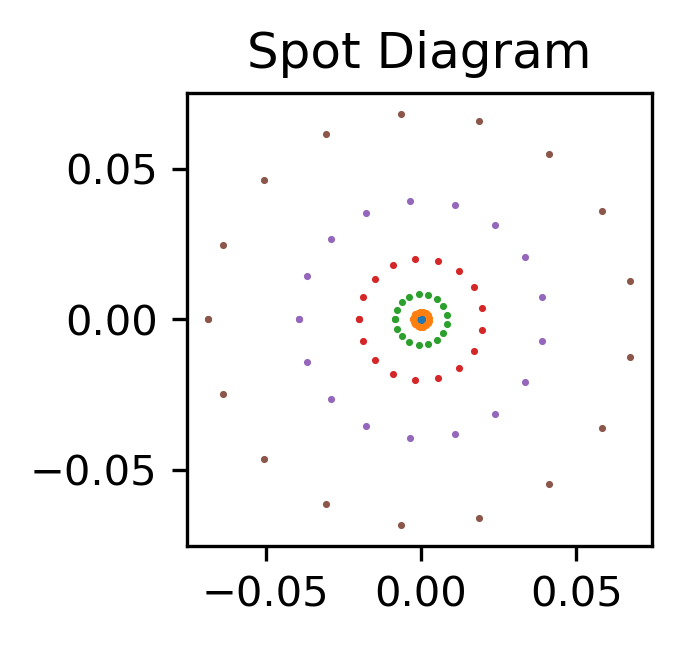

In [51]:

ang = np.linspace(0, 2*np.pi, 18)

plt.figure(figsize=(2, 2), dpi=300)

area = 0.5

for r in r_list:
    plt.scatter(r*np.cos(ang), r*np.sin(ang), s=area, marker='o')
    plt.title('Spot Diagram')
plt.show()




### 4. 实验总结

**这是光学Project的第三个小实验。受时间和空间的限制，我报告里所记录的内容有限。但是我在这个问题上的探索和付出远远多于我所得到的几个宝贵的参数。之前很多次实验都失败了。不知道经历了多少次报错，多少个夜晚，多少次迭代失败，多少次提前终止...通过不断的调试，不断的debug，不断的改进优化方式.最后把模型调整的比较稳定，也得到了比较合理的几组参数。我也很有信心我的GEO就是全局最优解~**

**但其实无论如何，我通过这个项目所得到的远远比最优解多得多~**

# 如果您对代码或者结果有任何问题，请联系 QQ：2857653516

# 谢谢！